# Tutorial 2: Implementing the model and training pipeline

### Outline

* Imports, including the library code from previous step
* Description of LSTM-based models
* Defining the training loop and procedure
* Setting hyperparameters and region of interest
* Running the model training
* Recording model configuration and saving the trained model
* Putting the model architecture code into a library module

## Setup and configuration

Before we get to the core of the tutorial, actually building and training a neural network, we need to do all of the normal setup. This includes a standard set of imports, but also includes our first import from the local codebase which is in the `src` folder. Here we are going to import some functions from the `src.datapipes` module, which contains the key portions of the code from the previous tutorial on actually loading in the data. By offloading this to code in a python module we can make the actual content of this step of the tutorial much clearer. Additionally, this gives us a start of a python package that might be useful to others and could be adapted to be generally importable. Finally, after our imports we set the default `DEVICE` to use a GPU if it is available, and fall back to CPU if not.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch
import yaml

from torch import nn
from tqdm.autonotebook import tqdm

# Code from the last part of the tutorial!!
from src.datapipes import make_data_pipeline, merge_data, select_region

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

/tmp/ipykernel_1035/3029422663.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Creating the data pipeline

If you followed along with the previous section of the tutorial you know the general pieces of info that go into setting up the data pipeline for our dataset, which culminated in developing the `make_data_pipeline` function. Before fully defining the pipelines, let's define our train/valid/test split. There are many ways to do this, and it's one of the most important parts of a rigorous machine learning pipeline. In our case, we'll just use a temporal split to define this, but our workflow is already set up quite nicely to use different regions for the splitting mechanism. Anyhow, for the tutorial we just set the splits as such:

In [2]:
train_period = slice('1985', '2000')
valid_period = slice('2001', '2007')
test_period = slice('2008', '2015')

ds = merge_data()

train_ds = ds.sel(time=train_period)
valid_ds = ds.sel(time=valid_period)
test_ds = ds.sel(time=test_period)

Given that, we can set up all of the rest of the pipeline configuration. This includes the region we're interested in modeling, the input and output variables, and the timescales we'll model with. Most of this code should be pretty self-explanatory, but it's probably worth highlighting the `input_sequence_length` and `output_sequence_length` variables. As we will get into, we'll be training a "recurrent neural network" (RNN), which processes variables sequentially and has the ability to store some "hidden state" which is able to track information coming in from past inputs. The reason that we specify different input/output sequence lengths is because we know that snowpack has a long-term dependence on temperature and precipitation. So, we define a much longer input sequence lenth than output sequence length to capture this long-term dependence. We set the input to be 360 days to be able to account for roughly a full year of input data, and the output to be 30 so that we predict about a month of snowpack dynamics for any given input.  This asymmetry amounts to letting the model "spin up" it's hidden state for the first 330 days and then start to output for the last 30. These are arbitrary choices in our case, which account for some level of knowledge that we have about snow hydrology, but could be further tuned as "hyperparameters". As a last note, we set the `input_overlap` to be the difference between the input and output sequence lengths as a way to take advantage of as much as data as possible in the training dataset.

In [3]:
regions = 'WNA'
input_vars = ['cbrt_pr',  'tasmax',  'tasmin',  'elevation',  'aspect_cosine']
output_vars = ['cbrt_swe']
input_sequence_length = 360
output_sequence_length = 30
batch_dims={'lat': 30, 'lon': 30}
input_overlap={'time': input_sequence_length - output_sequence_length} 

With everything set up, we can use our handy `make_data_pipeline` function to create the pipes for the training and validation datasets. Note how these make use of all of our metadata/hyperparameters from above in a nicely encapsulated way. This could ideally even be taken to other problems where similar datasets are being used, perhaps for something like soil moisture modeling.

In [4]:
train_pipe = make_data_pipeline(
    train_ds, regions,
    input_vars, output_vars,
    input_sequence_length, output_sequence_length,
    batch_dims, input_overlap, preload=True, dtype=DTYPE
)

valid_pipe = make_data_pipeline(
    valid_ds, regions,
    input_vars, output_vars,
    input_sequence_length, output_sequence_length,
    batch_dims, input_overlap, preload=True, dtype=DTYPE
)

## Developing the model structure

We have finally gotten to the point where we can start developing our model structure. This part is going to be quite concise in terms of the code that we'll use, but behind such a short amount of code are many years code and mathematical development. We'll take a brief detour to understand how/why we use the methods we do before moving on.

The model structure that we'll use here is the "Long Short Term Memory Network", commonly referred to simply as an LSTM ([Hochreiter and Schmidhuber, 1997](https://doi.org/10.1162/neco.1997.9.8.1735)). The LSTM is a popular variant of a class of neural networks called "recurrent neural networks" (RNN), which essentially process information sequentially. They were developed to address limitations of traditional RNNs when training on long sequences and have been popular in many areas including hydrology. Their use in modeling hydrologic processes has included streamflow ([Kratzert et al, 2017](https://doi.org/10.5194/hess-22-6005-2018)), soil moisture ([Sungmin and Orth, 2021](https://doi.org/10.1038/s41597-021-00964-1)), and snow ([Wang et al, 2022](https://doi.org/10.1029/2021WR031033)), among other applications.

Before jumping into the code, let's take a moment to actually see how LSTMs work. We will onlly scratch the surface, but a nice in-depth explanation of how and why LSTMs work see [Chris Olah's blog on "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). The basic idea behind an RNN, generally, is that it will take an (unbatched) input with dimensions `(sequence_length, num_features)`, where `sequence_length` represents inputs that have a particular order (e.g. time) and `num_features` are the number of relevant variables (e.g. temperature, precipitation). Then for every element along the `sequence_length` dimension the following equations are computed:

$$
i_t = \sigma \left( W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi} \right)  \\
f_t = \sigma \left( W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf}  \right) \\
g_t = \text{tanh} \left( W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg} \right) \\
o_t = \sigma \left( W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho} \right) \\
c_t = f_t \odot c_{t-1} + i_t \odot g_t
h_t = o_t \odot \text{tanh}(c_t)
$$

where $t$ is the timestep index, $\sigma$ is the sigmoid function, $\odot$ is the Hadamard (or elementwise) product, $h_t$ is the hidden state, $c_t$ is the cell state, $x_t$ is the input. $W_{\cdot\cdot}$ represents learnable weight matrices and $b_{\cdot\cdot}$ represent biases. The gate names are: 
* $o$: Output gate
* $i_t$: Input gate
* $f_t$: forget gate
* $g_t$: cell gate
* $o_t$: output gate

Diagramattically this can be represented from the popular figure from [Chris Olah's blog on "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/):

<div>
    <img src=https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="800px">
</div>

With all of this background understanding in tow, we can start to tackle the practical problem of building our model. For the most part we can rely on off-the-shelf components, but it's worth seeing how to implement a (very) basic neural network layer in the pytorch framework. To be clear, what follows could be implemented inside of something like the training loop, but [training neural networks is a leaky abstraction](http://karpathy.github.io/2019/04/25/recipe/) and as often as possible, it is better to decouple what your model *does* from how *well* it does it.

As we saw, an LSTM network can take an input of dimensions `(batch, timesteps, features)` and output `(batch, timesteps, targets)`. But, it's often the case (including here) where the number of input timesteps won't match the number of target timesteps. From an abstract standpoint this is exactly the same consideration as converting the *features* dimension to a *target* dimension. But unlike situations like language translation where the length of an input and output sequence length may be decoupled, we claim that any change in snowpack can only be a result of the meteorologic conditions from today or the past. As such, we further claim that the current snowpack state is only a function of some history of meteorologic states. This is exactly how we've set up the data loaders!

To take advantage of this, and the setup of the standard LSTM module from pytorch we can define the `LSTMOutput` class, which is a neural network "layer", that simply truncates the output time length to whatever is specified via the `out_len` variable. This is done in standard python fashion by declaring the class and `__init__` consstructor method, as well as standard pytorch fashion by defining the `forward` method which tells pytorch how to handle the forward application, while the backpropagation can be handled via pytorch's internal machinery.

In [5]:
class LSTMOutput(nn.Module):
    def __init__(self, out_len=1):
        super().__init__()
        self.out_len = out_len
        
    def forward(self,x):
        # nn.LSTM returns (output, (hn, cn)), so we just
        # want to grab the `output`
        # Output shape (batch, sequence_length, hidden)
        output, _ = x
        # Now just grab the last index on the sequence length
        # Reshape shape (batch, output_timesteps, hidden)
        return output[:, -self.out_len:, :]

With our custom layer set up we can start to build our model that will (hopefully) do something useful! In the act of doing this we will be good scientists and put the full model creation workflow into a function that can take even more hyperparameters into consideration. We'll set some defaults here just to get things started. Then, in the `create_lstm_model` function we simply create a new overall model structure by chaining together layers, starting with the pytorch implementation of the LSTM, followed by our `LSTMOtput` layer that select on time, followed by a linear layer to project the dimensionality from the `hidden_size` down to the `output_size`, and finally a "LeakyReLU" layer which basically reduces the ability of the model to produce negative snow, but also reduces the the [dead neuron effect](https://towardsdatascience.com/neural-network-the-dead-neuron-eaa92e575748). This is, admittedly, an architectural choice that could be dropped or modified, but does appear to work reasonably well as you will see.

In [6]:
hidden_size = 128
num_layers = 1
learning_rate = 3e-3
dropout = 0.0
max_epochs = 20

def create_lstm_model(
    input_size, 
    hidden_size, 
    output_size, 
    output_sequence_length,
    num_layers, 
    dropout
):
    model = nn.Sequential(
        nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        ),
        LSTMOutput(output_sequence_length),
        nn.Linear(in_features=hidden_size, out_features=output_size),
        nn.LeakyReLU(),
    )
    return model

From this we can easily create new models in a programattic way, which makes hyperparameter tuning and reproducibility much easier. We can use this function right away, given all of our other configuration. But, before we can actually train the model there are a couple other pieces that need to be connected. Namely a loss function and optimizer. These both have many options including those implemented by default via the pytorch library but are generally beyond the scope of this tutorial. We'll just use the standard `Adam` optimizer (with  learning rate hyperparameter defined above) and mean squared error loss here. The last thing we'll do is define one last optional piece, the `scheduler`. which tells the optimizer how to set the learning rate throughout the process. Here we will use the `OneCycleLR` scheduler, which basically starts with a very small learning rate and increases it after each epoch until plateauing about a third of the way through and finally slowly decaying back to a small learning rate. This type of learning rate scheduler has been found to decrease the training time to reach a comparable loss compared to models trained without it.

In [7]:
model = create_lstm_model(
    len(input_vars), 
    hidden_size, 
    len(output_vars), 
    output_sequence_length, 
    num_layers, 
    dropout
)

model = model.to(DTYPE).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fun = nn.MSELoss()  
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=learning_rate, epochs=max_epochs, steps_per_epoch=1
)

## Some quick model/data verification

Many tutorials would jump straight into training the model now, but from a practical standpoint, it's worth making sure that your data inputs/outputs match up in the way that you expect them to before getting too deep. This can largely be a matter of trial and error in the worst case, but if you are careful and understand everything that happens in your model it is merely a formality. Starting here we'll first see that our input and output batches contain differences along both the `timesteps` and `features` dimensions. This should come as no surprise, but quantifying it should be a good "gut check". Similarly, we can make sure that the output of our model is the same as the target from the dataloader. If this is not the case something is wrong and you will need to go back in the data/model workflow to debug what's going on before you can train your model.

In [8]:
x, y = next(iter(train_pipe))
x = x.to(DEVICE)
y = y.to(DEVICE)

print('Dims are: (batch, timesteps, features)')
print(x.shape, y.shape)

with torch.no_grad():
    print(
        'Model targets match output ',
        model(x).shape == y.shape
    )

Dims are: (batch, timesteps, features)
torch.Size([232, 360, 5]) torch.Size([232, 30, 1])
Model targets match output  True


## Setting up the training procedure

At this point we have confirmed that our model and dataloaders can interoperate, so it's time to actually figure out how to train the model using our data to produce something useful. To do that we'll define the `train_epoch` function which takes our model, data loader, optimizer, and loss function as inputs. It will run over the entire dataset and calculate the model outputs, comparing them against the targets using the loss function. If used with the `train` flag set to true we will update the model parameters after every batch is processed via the `opt.step()` function. We also implement some custom behavior if `train` is set to false that will save on computation during the validation steps. Finally, this function will return the average loss over the overall epoch, although you could modify the function to return the full series of losses across training batches.

In [9]:
def train_epoch(model, dl, opt, loss_fun, train=True, device=DEVICE, dtype=DTYPE):
    avg_loss = 0.0
    for i, batch in tqdm(enumerate(dl)):
        x, y = batch
        if not len(x): continue
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        if train:
            yhat = model(x)
        else:
            # Don't compute gradients
            # Saves on computation
            with torch.no_grad():
                yhat = model(x)
        loss = loss_fun(yhat, y)
        if train:
            loss.backward()
            opt.step()
        avg_loss += loss.cpu().detach().float().numpy()
    return avg_loss / i

## Time for model training

And that's it, we're ready to actually run the training procedure! We will initialize some lists for recording the training and validation losses and also set the maximum number of epochs to run the training on. For simplicity, we've set this to 20 epochs which runs in approximately 45 minutes when running on the Planetary Computer pytorch environment with a T4 GPU. If you just want to get a baseline model that doesn't work very well you can lower this number, or alternatively if you have more time to kill you can set this to a higher number and really start to push the limits of this model/data!

In [10]:
train_loss = []
valid_loss = []

In [11]:
for e in (bar := tqdm(range(max_epochs))):
    # Make sure to turn on train mode here
    # so that we update parameters
    model.train()
    tl = train_epoch(model, train_pipe, opt, loss_fun, train=True)
    # Now set to evaluation mode which reduces
    # the memory/computational cost
    model.eval()
    vl = train_epoch(model, valid_pipe, opt, loss_fun, train=False)
    # Log our losses and update the status bar
    train_loss.append(tl), valid_loss.append(vl)
    scheduler.step()
    bar.set_description(f'Train loss: {tl:0.1e}, valid loss: {vl:0.1e}')

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

If you've made it this far, you can finally see how the training progressed! We simply plot some loss curves below.

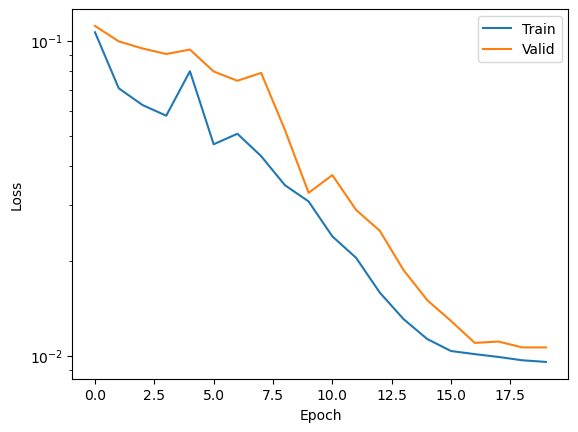

In [12]:
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy()
plt.savefig('loss.png')

## A very light introduction to MLOps

Congratulations! You've trained a model. Now what? Before you go ahead and start analyzing the trained model here in this very notebook take a deep breath. We're going to stop you while you are ahead. Doing model training and evaluation in the same notebook or script is dangerous indeed, and makes it quite easy to end up getting really good false-results which can be chalked up to [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)). This is an important consideration that we'll come back to later, particularly because we've chosen to train our model on a particular region and then test and apply it to the same region in the following tutorial steps, but it would be even more robust to test/apply the model to regions which weren't included in the training datset. Anyhow, more on that later.

For now, we just need a way to record the experimental decisions that we've made in this tutorial step with relative completeness. There are many MLOps frameworks which can handle this at scale such as [Weights and Biases](https://wandb.ai/site) and [MLFlow](https://mlflow.org/), but they are a bit too complex to cover here. Basically, the idea here is that we want to capture all of the essential pieces of the training workflow that we just did so that we can not only reproduce the trained model, but also so that we can make sure we can take the trained model and use it on new data. 

In the process of this we'll just develop a simple set of functions which can save and load "experiments" which are really just collections of attributes and hyperparameter values that we've set throughout this tutorial. From a high level we splt this into the `data_config` and `model_config` which is simply stored as the dictionary supplied below:


In [13]:
experiment_config = {
    "data_config": {
        # Note: using `start`/`stop` attributes so we save a tuple
        "train_period": (train_period.start, train_period.stop),
        "valid_period": (valid_period.start, valid_period.stop),
        "test_period": (test_period.start, test_period.stop),
        "regions": regions,
        "input_vars": input_vars,
        "output_vars": output_vars,
        "input_sequence_length": input_sequence_length,
        "output_sequence_length": output_sequence_length,
        "batch_dims": batch_dims,
        "input_overlap": input_overlap
    },
    "model_config": {
        "input_size": len(input_vars),
        "hidden_size": hidden_size,
        "output_size": len(output_vars),
        "output_sequence_length": output_sequence_length,
        "num_layers": num_layers,
        "dropout": dropout
    },
}

Given that dictionary structure we want to simply write out a file that records all of that info. And similarly, can read that information back in at a later date. For this use case we'll use the [yaml](https://yaml.org/) file format.

In [14]:
def save_experiment(config, output_dir, name, model=None):
    outfile = f"{output_dir}/{name}.yml"
    if model:
        # We have a trained model that we should save the weights for
        # so we write that as a separate file and then also record 
        # where we wrote those to via the `weights_file` key
        config["weights_file"] = f"{output_dir}/{name}.pt"
        torch.save(model.state_dict(), f"{output_dir}/{name}.pt")
    with open(outfile, "w") as f:
        yaml.dump(config, f)
    return outfile


def load_experiment(config_path):
    with open(config_path, "r") as f:
        config = yaml.load(f)
    return config

With this set of functions defined we can then make use of them. First, we'll just save an experiment file out, which has the name `tutorial` and also provides our model structure via the `model` keyword. This ensures that the trained model parameters are saved out and can be loaded in, in the next tutorial.

In [15]:
f = save_experiment(
    config=experiment_config, 
    output_dir="../experiments/tutorial", 
    name="tutorial", 
    model=model
)

We demonstrate that things are all good, and nothing has been lost by making sure to test the `load_experiment` function as well as using the `create_lstm_model` which we defined earlier given the `model_config` section of our saved out experiment. We finalize everything by proving that we can not only instantiate the model structure, but also can load back in the exact same saved out model via the `weights file`. Given all of this we are ready to evaluate the model on our held out test data!

In [16]:
experiment_config = load_experiment(f)
experiment_config

loaded_model = create_lstm_model(**experiment_config['model_config'])
loaded_model.load_state_dict(torch.load(experiment_config['weights_file']))

<All keys matched successfully>